(32, 1)
(32, 1)


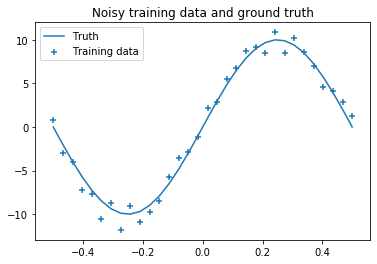

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
t = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

print(X.shape)
print(t.shape)

plt.scatter(X, t, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()
plt.show()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

In [3]:
np.sqrt(0.5 * 1.5 ** 2 + 0.5 * 0.1 ** 2)


1.0630145812734648

In [4]:
class DenseVariational(tf.keras.Model):
    def __init__(self, unit):
        super(DenseVariational, self).__init__()
        
        self.unit = unit
        
        self.w_mean = None
        self.w_rho = None
        
        self.b_mean = None
        self.b_rho = None
        
        self.prior_sigma_1 = 1.5
        self.prior_sigma_2 = 0.1
        self.prior_pi_1 = 0.5
        self.prior_pi_2 = 0.5
        
    def _initialize_weights(self, input_dim):
        self.w_mean = tf.Variable(tf.random.normal([input_dim, self.unit], stddev=1.0))
        self.b_mean = tf.Variable(tf.random.normal([self.unit,], stddev=1.0))
        
        self.w_rho = tf.Variable(tf.zeros([input_dim, self.unit])-2)
        self.b_rho = tf.Variable(tf.zeros([self.unit,])-2)
        
    def get_kl_loss(self, batch, w, mean, stddev):
        variational_dist = tfp.distributions.Normal(mean, stddev)
        posterior_log_prob = variational_dist.log_prob(w)
        
        normal_dist = tfp.distributions.Normal(0, 1)
        prior_log_prob = normal_dist.log_prob(w)
        print('kl :', posterior_log_prob.shape, prior_log_prob.shape)
        
        return 1 / batch * tf.reduce_sum(posterior_log_prob - prior_log_prob)
    
    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return tf.math.log(self.prior_pi_1 * comp_1_dist.prob(w) + self.prior_pi_2 * comp_2_dist.prob(w))
        
    def call(self, x):
        if self.w_mean is None:
            self._initialize_weights(x.shape[-1])
            
        w_stddev = tf.nn.softplus(self.w_rho)
        weight = self.w_mean + w_stddev * tf.random.normal(self.w_mean.shape)
        
        b_stddev = tf.nn.softplus(self.b_rho)
        bias = self.b_mean + b_stddev * tf.random.normal(self.b_mean.shape)
        
        kl_loss = self.get_kl_loss(x.shape[0], weight, self.w_mean, w_stddev) + \
                  self.get_kl_loss(x.shape[0], bias, self.b_mean, b_stddev)
        
        y = x @ weight + bias
        #y = x @ self.w_mean + self.b_mean

        return y, kl_loss
    
    
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = DenseVariational(20)
        self.layer2 = DenseVariational(20)
        self.layer3 = DenseVariational(20)
        self.layer4 = DenseVariational(20)
        self.layer5 = DenseVariational(1)
        
    def call(self, x, t, predict=False):
        # x : [batch, 1]
        # t : [batch, 1]
        
        kl_losses = 0
        y, kl_loss = self.layer1(x)
        kl_losses += kl_loss
        y = tf.nn.relu(y)

        y, kl_loss = self.layer2(y)
        kl_losses += kl_loss
        y = tf.nn.relu(y)
        
        y, kl_loss = self.layer3(y)
        kl_losses += kl_loss
        y = tf.nn.relu(y)
        
        y, kl_loss = self.layer4(y)
        kl_losses += kl_loss
        y = tf.nn.relu(y)
        
        y, kl_loss = self.layer5(y)
        kl_losses += kl_loss
        
        if not predict:
            dist = tfp.distributions.Normal(loc=y, scale=1.0)
            nll = -dist.log_prob(t)
            #print('nll :', nll.shape)

            nll_loss = tf.reduce_sum(nll)
            #nll_loss = tf.reduce_sum((t - y) ** 2)
            total_loss = nll_loss + kl_losses
            
            return y, nll_loss, kl_losses, total_loss
        
        return y
        
        

In [5]:
model = Model()
print(model)

optimizer = tf.keras.optimizers.Adam(1e-3)

In [6]:
X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)

y, nll_loss, kl_losses, total_loss = model(X_tensor, t_tensor)

TypeError: in converted code:

    <ipython-input-4-d1b7136b4426>:73 call
        y, kl_loss = self.layer1(x)
    <ipython-input-4-d1b7136b4426>:42 call
        self._initialize_weights(x.shape[-1])
    <ipython-input-4-d1b7136b4426>:19 _initialize_weights
        self.w_mean = tf.Variable(tf.random.normal([input_dim, self.unit], stddev=1.0))
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/ops/random_ops.py:74 random_normal
        shape_tensor = _ShapeTensor(shape)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/ops/random_ops.py:44 _ShapeTensor
        return ops.convert_to_tensor(shape, dtype=dtype, name="shape")
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1087 convert_to_tensor
        return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1145 convert_to_tensor_v2
        as_ref=False)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1224 internal_convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:305 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:246 constant
        allow_broadcast=True)
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:284 _constant_impl
        allow_broadcast=allow_broadcast))
    /home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:562 make_tensor_proto
        "supported type." % (type(values), values))

    TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: [Dimension(1), 20]. Consider casting elements to a supported type.


In [8]:
#@tf.function
def train_step(model, optimizer, X_tensor, t_tensor):
    
    with tf.GradientTape() as tape:
           
        y, nll_loss, kl_losses, total_loss = model(X_tensor, t_tensor)
        
    gradient = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    return y, nll_loss, kl_losses, total_loss
        

In [10]:
from IPython import display
from tqdm.notebook import tqdm

while(True):
    
    for i in tqdm(range(300)):
        y, nll_loss, kl_losses, total_loss = train_step(model, optimizer, X_tensor, t_tensor)
        print(nll_loss, kl_losses, total_loss)
    
    display.clear_output()

    X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
    y_pred_list = []

    for i in tqdm(range(50)):
        y_pred = model(X_test, None, predict=True)
        y_pred_list.append(y_pred)

    y_preds = np.concatenate(y_pred_list, axis=1)    

    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
    plt.scatter(X, t, marker='+', label='Training data')
    plt.fill_between(X_test.ravel(), 
                     y_mean + 2 * y_sigma, 
                     y_mean - 2 * y_sigma, 
                     alpha=0.5, label='Epistemic uncertainty')
    plt.title('Prediction')
    plt.legend()
    plt.show()

kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tensor(7777.635, shape=(), dtype=float32) tf.Tensor(86.07315, shape=(), dtype=float32) tf.Tensor(7863.708, shape=(), dtype=float32)
kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tensor(9796.826, shape=(), dtype=float32) tf.Tensor(85.13253, shape=(), dtype=float32) tf.Tensor(9881.959, shape=(), dtype=float32)
kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tensor(3798.523, shape=(), dtype=float32) tf.Tensor(85.924324, shape=(), dtype=float32) tf.Tensor(3884.4473, shape=(), dtype=float32)
kl : (1, 20

tf.Tensor(4805.8604, shape=(), dtype=float32) tf.Tensor(86.27933, shape=(), dtype=float32) tf.Tensor(4892.1396, shape=(), dtype=float32)
kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tensor(26704.625, shape=(), dtype=float32) tf.Tensor(85.53729, shape=(), dtype=float32) tf.Tensor(26790.162, shape=(), dtype=float32)
kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tensor(4754.4814, shape=(), dtype=float32) tf.Tensor(83.61557, shape=(), dtype=float32) tf.Tensor(4838.097, shape=(), dtype=float32)
kl : (1, 20) (1, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 20) (20, 20)
kl : (20,) (20,)
kl : (20, 1) (20, 1)
kl : (1,) (1,)
tf.Tenso

KeyboardInterrupt: 